In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #130
!cp -r '/content/gdrive/MyDrive/In-Bed-Human-Pose-Estimation(VIP-CUP)' /content

Mounted at /content/gdrive


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Register Dataset

In [4]:
import glob
def sort_by_subject(x):return int(x[-5:])
def sort_by_img_name(x):return int(x[-10:-4])


train_uncover=  []
for data_dir in glob.glob('In-Bed-Human-Pose-Estimation(VIP-CUP)/train/*'):
    if int(data_dir[-5:])<=30:train_uncover.append(data_dir)
train_uncover_dirs= sorted(train_uncover, key=sort_by_subject)

In [5]:
import scipy.io
import matplotlib.pyplot as plt
from detectron2.data import MetadataCatalog


def get_paired_uncover_data(train_uncover_dirs, type_='RGB', n_samples=None):
    img_id=1
    img_dict_list = []
    break_flag= False
    for train_uncover_dir in train_uncover_dirs:
        img_dirs = sorted(glob.glob(f'{train_uncover_dir}/{type_}/uncover/*.png'), key = sort_by_img_name)
        joints_dir =  f'{train_uncover_dir}/joints_gt_{type_}.mat'
        joints_all = scipy.io.loadmat(joints_dir)['joints_gt']

        for img_dir in img_dirs: 
            
            img_number = img_dir[-10:-4]
            joints = joints_all[:,:,int(img_number)-1].T
            
            img= plt.imread(img_dir)
            if type_=='RGB':height, width, _ = img.shape
            else:height, width = img.shape

            #joints[:, 0]= joints[:,0]/width #x
            #joints[:, 1]= joints[:,1]/height #y
            joints[:, 2]= np.ones((14,)).astype('float')
            joints_flatten= joints.flatten()
            
            x_max= joints[:, 0].max()
            x_min= joints[:, 0].min()

            y_max= joints[:, 1].max()
            y_min= joints[:, 1].min()

            annotations= [{'bbox': [x_min, y_max, x_max, y_min],
                           'bbox_mode':0,
                           'category_id':0,
                           'keypoints':joints_flatten}]

            img_dict = {'file_name':img_dir, 'height':height, 'width':width, 'image_id':img_id, 'annotations':annotations}
            img_dict_list.append(img_dict)
            
            if img_id%100==0:print(img_id)
            img_id+=1

            if n_samples!=None:
                if img_id>n_samples:
                    break_flag=True
                    break
        if break_flag==True:break
            
    return img_dict_list    


def set_metadata(dataset_name, colors_edgs):
    # 1: l: left, r: right
    # 2: l: leg, h: hand
    # 3: b: bottom, m: middle, u: upper


    #MetadataCatalog.get("paired_lwir_uncover").keypoint_names = ['llb','llm', 'llu', 'rlu', 'rlm', 'rlb', 'lhb', 'lhm', 'lhu', 'rhu', 'rhm', 'rhb', 'neck', 'head']
    #MetadataCatalog.get("paired_lwir_uncover").keypoint_flip_map = [('llb', 'rlb'),('llm', 'rlm'),('llu', 'rlu'),('lhb', 'rhb'),('lhm', 'rhm'),('lhu', 'rhu')]

    MetadataCatalog.get(dataset_name).keypoint_names = ['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
    MetadataCatalog.get(dataset_name).keypoint_flip_map = [('1', '6'),('2', '5'), ('3', '4'), ('7', '12'), ('8', '11'), ('9', '10')]

    MetadataCatalog.get(dataset_name).keypoint_connection_rules = [('1', '2', colors_edgs[0]), ('2', '3', colors_edgs[1]), ('3', '9', colors_edgs[2]), ('6', '5', colors_edgs[3]), ('5', '4', colors_edgs[4]), ('4', '10', colors_edgs[5]), ('7', '8', colors_edgs[6]), ('8', '9', colors_edgs[7]), ('12', '11', colors_edgs[8]), ('11', '10', colors_edgs[9]), ('9', '13', colors_edgs[10]), ('10', '13', colors_edgs[11]), ('13', '14', colors_edgs[12])]

In [6]:
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
import shutil

rainbow_color_map= np.load('/content/gdrive/MyDrive/In-Bed-Human-Pose-Estimation(VIP-CUP)/Detectron2_supplementary_udith/mapvals_rainbow-gray_new.npy')[:-6]
rainbow_color_map= rainbow_color_map*np.ones((20, rainbow_color_map.shape[0], 3))

rainbow_color_map = cv2.resize(rainbow_color_map, (13, 20), interpolation=cv2.INTER_CUBIC)
rainbow_color_map_array= rainbow_color_map[0]

In [7]:
from detectron2.data import DatasetCatalog

def register_dataset(dataset_name, data_dirs, type_, n_samples, color_edgs):
    def get_data(n_samples=n_samples):return get_paired_uncover_data(data_dirs, type_=type_, n_samples=n_samples)
    DatasetCatalog.register(dataset_name, get_data)
    set_metadata(dataset_name, color_edgs)

idx=np.random.randint(low= 5000, high=1000000000000)

color_edgs= list(map(tuple, (255*rainbow_color_map_array).astype('uint8')))

uncover_rgb_train_dataset_name = f"paired_rgb_uncoverv{idx}_train"
uncover_rgb_test_dataset_name = f"paired_rgb_uncoverv{idx}_test"
uncover_lwir_train_dataset_name = f"paired_lwir_uncoverv{idx}_train"
uncover_lwir_test_dataset_name = f"paired_lwir_uncoverv{idx}_test"

n_samples= None
register_dataset(uncover_rgb_train_dataset_name, train_uncover_dirs[:24], 'RGB', n_samples, color_edgs)
register_dataset(uncover_rgb_test_dataset_name, train_uncover_dirs[24:], 'RGB', n_samples, color_edgs)

register_dataset(uncover_lwir_train_dataset_name, train_uncover_dirs[:24], 'IR', n_samples, color_edgs)
register_dataset(uncover_lwir_test_dataset_name, train_uncover_dirs[24:], 'IR', n_samples, color_edgs)

## Predict Pose

In [8]:
!mkdir /content/checkpoints
!cp -r '/content/gdrive/My Drive/In-Bed-Human-Pose-Estimation(VIP-CUP)/Detectron2_supplementary_udith/saved_outputs/lwir_uncover' '/content/checkpoints'
!cp -r '/content/gdrive/My Drive/In-Bed-Human-Pose-Estimation(VIP-CUP)/Detectron2_supplementary_udith/saved_outputs/rgb_uncover' '/content/checkpoints'

In [9]:
def get_cfg_for_test(dataset_name_test, checkpoint_dir):
    cfg = get_cfg()  
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TEST = (dataset_name_test,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 0 #300    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # human

    ###
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 14
    cfg.TEST.DETECTIONS_PER_IMAGE = 1
    ###
    cfg.OUTPUT_DIR= checkpoint_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg

In [10]:
def predict_poses(images, dataset_name, checkpoint_dir):
    tuned_model_dir = 'model_final.pth'

    cfg= get_cfg_for_test(dataset_name, checkpoint_dir)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, tuned_model_dir)  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    pred_images = []
    pred_annots = []
    for im in images:
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(dataset_name), scale=0.5)
      
        out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        pred_annot = out_pred.get_image()[:, :, ::-1]

        pred_images.append(pred_annot)
        pred_annots.append(outputs["instances"].to("cpu"))
    return pred_images, pred_annots

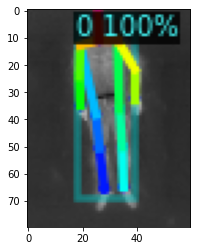

In [16]:
images_ir= [cv2.imread('In-Bed-Human-Pose-Estimation(VIP-CUP)/train/00025/IR/uncover/image_000003.png')]
pred_images_ir, pred_annots_ir =predict_poses(images_ir, uncover_lwir_test_dataset_name, '/content/checkpoints/lwir_uncover')

plt.imshow(pred_images_ir[0])
plt.show()

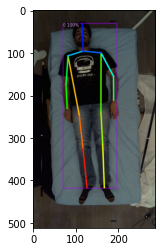

In [17]:
images_rgb= [cv2.imread('In-Bed-Human-Pose-Estimation(VIP-CUP)/train/00025/RGB/uncover/image_000003.png')]
pred_images_rgb, pred_annots_rgb = predict_poses(images_rgb, uncover_rgb_test_dataset_name, '/content/checkpoints/rgb_uncover')

plt.imshow(cv2.cvtColor(pred_images_rgb[0], cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
pred_annots_rgb[0].pred_keypoints.shape

torch.Size([1, 14, 3])